In [9]:
import math
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Flatten
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.models import load_model
import csv
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.utils import plot_model
from keras import optimizers
from keras import regularizers
import matplotlib.pyplot as plt

In [2]:
# Changeable parameter
train_dir = 'D:\capstone\dataset\Inat_2017_Extra\Aves_augmented_7class_train'
val_dir = 'D:\capstone\dataset\Inat_2017_Extra\Aves_augmented_7class_vali'
batch_size = 32
epoch_num = 12
load_prev_model = False
NB_IV3_LAYERS_TO_FREEZE = 249  # number of freezing layer
# Make sure to change this to the designated model
# prev_model_path = r'test_mini_4_epoch.h5'
model_metrics_path = r'InceptionV3_similar_7class_augmented-NB_IV3_LAYERS-history.csv'

In [3]:
# Non-changeable parameter
cur_model_path = r'D:\capstone\model_save\InceptionV3_similar_7class_augmented_NB_IV3_LAYERS.h5'

In [4]:
#Limiting the number of resources used, hopefully this works
#It kinda does, CPU usage is only around 40-50% ish
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
set_session(tf.Session(config=config))

In [5]:
# Default configuration from
# https://keras.io/preprocessing/image/
# With a little bit of change in parameter
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')

Found 6889 images belonging to 7 classes.
Found 1721 images belonging to 7 classes.


In [6]:
if load_prev_model == False:
    # Just to make sure that this is only being loaded once
    base_model = InceptionV3(include_top=False,weights='imagenet',input_shape=(299,299,3))

    x = base_model.output
    # Output shape is (1,1,2048) no need for GlobalAveragePooling
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freezing all the base model layers
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
         layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
         layer.trainable = True

    # and then compile the model
    adam=optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    model = load_model(prev_model_path)

In [8]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [7]:
# TRAINING CELL
num_train_samples = train_generator.samples
train_epoch_steps = math.ceil(num_train_samples / batch_size)
num_val_samples = validation_generator.samples
val_epoch_steps = math.ceil(num_val_samples / batch_size)
train_history = model.fit_generator(train_generator,
                    steps_per_epoch=train_epoch_steps,
                    epochs=epoch_num,
                    validation_data=validation_generator,
                    validation_steps=val_epoch_steps)

Epoch 1/12
216/216 [==============================] - 310s 1s/step - loss: 15.0963 - acc: 0.3467 - val_loss: 14.5721 - val_acc: 0.4654
Epoch 2/12
216/216 [==============================] - 273s 1s/step - loss: 14.1111 - acc: 0.5268 - val_loss: 13.7733 - val_acc: 0.5235
Epoch 3/12
216/216 [==============================] - 441s 2s/step - loss: 13.2892 - acc: 0.6233 - val_loss: 13.1138 - val_acc: 0.5607
Epoch 4/12
216/216 [==============================] - 347s 2s/step - loss: 12.5696 - acc: 0.6925 - val_loss: 12.5251 - val_acc: 0.5752
Epoch 5/12
216/216 [==============================] - 298s 1s/step - loss: 11.9282 - acc: 0.7323 - val_loss: 11.9900 - val_acc: 0.5834
Epoch 6/12
216/216 [==============================] - 424s 2s/step - loss: 11.3007 - acc: 0.7843 - val_loss: 11.4846 - val_acc: 0.6020
Epoch 7/12
216/216 [==============================] - 326s 2s/step - loss: 10.7437 - acc: 0.8086 - val_loss: 10.9902 - val_acc: 0.6124
Epoch 8/12
216/216 [==============================] - 2

In [ ]:
#Numbering the current epoch based on the previous epoch path
#Handling multiple re-run of the training cell as well
# split_prev_model_path = prev_model_path.split('_') if cur_model_path is None else cur_model_path.split('_')
# prev_epoch_number = int(split_prev_model_path[2])
# cur_epoch_number = prev_epoch_number + epoch_num
# cur_model_path = '_'.join(split_prev_model_path[:2]+[str(cur_epoch_number)]+split_prev_model_path[3:])

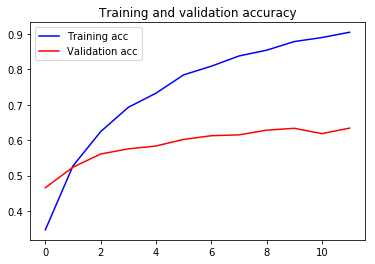

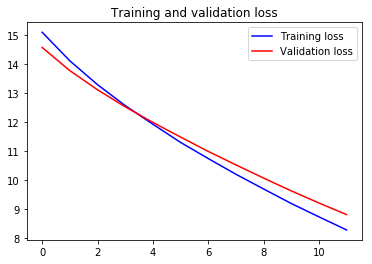

In [10]:
# Record the train history in the designated csv file
# Note: newline has to be '' due to the way csv writerow works
with open(model_metrics_path, 'a+', newline='') as history_file:
    csv_writer = csv.writer(history_file)
    for e in train_history.epoch:
        epoch_number = e
        csv_writer.writerow([epoch_number,
                            train_history.history['acc'][e],
                            train_history.history['loss'][e],
                            train_history.history['val_acc'][e],
                            train_history.history['val_loss'][e]])
        
acc = train_history.history['acc']
val_acc = train_history.history['val_acc']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [11]:
# Optionally save the model
#model.save(prev_model_path)
model.save(cur_model_path)